In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import bert
import pickle
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tqdm import tqdm as tqdm_base
def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

In [3]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [6]:
mean_confidence_interval([12.76, 12.41, 12.77, 12.62, 12.89, 12.58])

(12.671666666666667, 0.1785171974074619)

$|X_1| = n$, $|X_2| = m$

$ f:X_1 \rightarrow X_2$

$F(x_i^1, x_j^2): X1 \times X2 \rightarrow R$

In [2]:
def get_model(model_url, max_seq_length):
      labse_layer = hub.KerasLayer(model_url, trainable=True)

      # Define input.
      input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                             name="input_word_ids")
      input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_mask")
      segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                          name="segment_ids")

      # LaBSE layer.
      pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

      # The embedding is l2 normalized.
      pooled_output = tf.keras.layers.Lambda(
          lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

      # Define model.
      return tf.keras.Model(
            inputs=[input_word_ids, input_mask, segment_ids],
            outputs=pooled_output), labse_layer

max_seq_length = 64
labse_model, labse_layer = get_model(
    model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=max_seq_length)

In [3]:
vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def create_input(input_strings, tokenizer, max_seq_length):
    

  input_ids_all, input_mask_all, segment_ids_all = [], [], []
  for input_string in input_strings:
    # Tokenize input.
    input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
    sequence_length = min(len(input_ids), max_seq_length)

    # Padding or truncation.
    if len(input_ids) >= max_seq_length:
      input_ids = input_ids[:max_seq_length]
    else:
      input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    segment_ids_all.append([0] * max_seq_length)

  return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

def encode(input_text):
  input_ids, input_mask, segment_ids = create_input(
    input_text, tokenizer, max_seq_length)
  return labse_model([input_ids, input_mask, segment_ids])

english_sentences = ["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."]
italian_sentences = ["cane", "I cuccioli sono carini.", "Mi piace fare lunghe passeggiate lungo la spiaggia con il mio cane."]
japanese_sentences = ["犬", "子犬はいいです", "私は犬と一緒にビーチを散歩するのが好きです"]

english_embeddings = encode(english_sentences)
italian_embeddings = encode(italian_sentences)
japanese_embeddings = encode(japanese_sentences)

# English-Italian similarity
print (np.matmul(english_embeddings, np.transpose(italian_embeddings)))

[[0.6319286  0.3061978  0.44297493]
 [0.11652683 0.8596668  0.35940567]
 [0.14803976 0.3244797  0.954265  ]]


In [41]:
def get_optimal_quality(sim, dis):
    print(len(sim), len(dis))
    plt.hist(sim, color='red', bins=20, alpha=0.3, density=True)
    plt.hist(dis, color='blue', bins=20, alpha=0.3, density=True)
    plt.show()
    all_data = list(sim) + list(dis)
    ys = [1]*len(sim) + [0]*len(dis)
    best_score = 0
    max_f = 0
    best_thr = 0
    for thr in np.arange(0, 1, 0.01):
        pred = [1 if x > thr else 0 for x in all_data]
        p, r, f1, s = precision_recall_fscore_support(ys, pred, average='binary')
        if f1 > max_f:
            best_score = (p, r, f1, s)
            max_f = f1
            best_thr = thr
    return best_score, best_thr

In [5]:
embeddings_dict = {}

l = 'ky_ru'
path_1 = '/data2/Anypair/joeynmt/test/data_ky_ru/data/' + 'dev.' + l.split('_')[0]
with open(path_1, "r") as f:
    content = f.readlines()

sents_1 = [x.strip() for x in content]

path_2 = '/data2/Anypair/joeynmt/test/data_ky_ru/data/' + 'dev.' + l.split('_')[1] 
with open(path_2, "r") as f:
    content = f.readlines()

sents_2 = [x.strip() for x in content]
    
    
embeddings_ky = encode(sents_1[:2000])
embeddings_ru = encode(sents_2[:2000])
    
name = l.split('_')[0] + '_' + l.split('_')[1]
embeddings_dict[name] = [embeddings_ky,  embeddings_ru]

ky_ru
2000 1999000


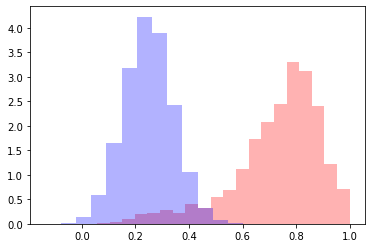

(0.8327566320645905, 0.722, 0.7734333154793787, None) 0.67


In [6]:
for key in embeddings_dict.keys():
    print(key)
    similarity_matrix = (np.matmul(embeddings_dict[key][0], np.transpose(embeddings_dict[key][1])))
    s  = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k = 1)]  
    u_max_f, u_best_thr = get_optimal_quality(np.diagonal(similarity_matrix), s)
    print(u_max_f, u_best_thr)

In [6]:
#from numba import cuda 
#device = cuda.get_current_device()

In [7]:
#device.reset()

# Finding nearest

with open("untouch_embeds_ky","wb") as fp:
    pass
with open("untouch_embeds_ru","wb") as fp:
    pass

In [40]:
l = 'ky_ru'
path_1 = '/data2/Anypair/joeynmt/test/data_ky_ru/data/' + 'untouchable.' + l.split('_')[0]
with open(path_1, "r") as f:
    content_ky = f.readlines()

sents_ky = [x.strip() for x in content_ky]



for i in tqdm(range(0,len(sents_ky),1000)):
    embeddings_ky = encode(sents_ky[i:i+1000])

      
    if i == 0:
        with open("untouch_embeds_ky","wb") as fp:
            pickle.dump(embeddings_ky, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    else:
        with open("untouch_embeds_ky","rb") as fp:
            array = pickle.load(fp)
        concated_ky = np.concatenate((array,embeddings_ky), axis=0)
        with open("untouch_embeds_ky","wb") as fp:
            pickle.dump(concated_ky, fp, protocol=pickle.HIGHEST_PROTOCOL)
    









  0%|          | 0/110 [00:00<?, ?it/s]






  1%|          | 1/110 [00:07<12:48,  7.05s/it]






  2%|▏         | 2/110 [00:13<12:35,  7.00s/it]






  3%|▎         | 3/110 [00:20<12:26,  6.98s/it]






  4%|▎         | 4/110 [00:27<12:18,  6.97s/it]






  5%|▍         | 5/110 [00:34<12:11,  6.97s/it]






  5%|▌         | 6/110 [00:41<12:05,  6.97s/it]






  6%|▋         | 7/110 [00:48<11:58,  6.98s/it]






  7%|▋         | 8/110 [00:55<11:51,  6.98s/it]






  8%|▊         | 9/110 [01:02<11:45,  6.99s/it]






  9%|▉         | 10/110 [01:09<11:39,  7.00s/it]






 10%|█         | 11/110 [01:16<11:35,  7.02s/it]






 11%|█         | 12/110 [01:23<11:29,  7.04s/it]






 12%|█▏        | 13/110 [01:31<11:24,  7.06s/it]






 13%|█▎        | 14/110 [01:38<11:19,  7.08s/it]






 14%|█▎        | 15/110 [01:45<11:14,  7.10s/it]






 15%|█▍        | 16/110 [01:52<11:08,  7.11s/it]






 15%|█▌        | 17/110 [01:59<11:03,  7.13s/it]






 16%|█▋        | 18/1

In [43]:

l = 'ky_ru'

path_2 = '/data2/Anypair/joeynmt/test/data_ky_ru/data/' + 'untouchable.' + l.split('_')[1] 
with open(path_2, "r") as f:
    content_ru = f.readlines()

sents_ru = [x.strip() for x in content_ru]

for i in tqdm(range(0,len(sents_ru),1000)):#len(sents_ky)
    embeddings_ru = encode(sents_ru[i:i+1000])
        
    if i == 0:
        with open("untouch_embeds_ru","wb") as fp:
            pickle.dump(embeddings_ru, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    else:
        with open("untouch_embeds_ru","rb") as fp:
            array = pickle.load(fp)
        concated_ru = np.concatenate((array,embeddings_ru), axis=0)
        with open("untouch_embeds_ru","wb") as fp:
            pickle.dump(concated_ru, fp, protocol=pickle.HIGHEST_PROTOCOL)
        








  0%|          | 0/110 [00:00<?, ?it/s]






  1%|          | 1/110 [00:07<12:52,  7.09s/it]






  2%|▏         | 2/110 [00:13<12:38,  7.02s/it]






  3%|▎         | 3/110 [00:20<12:27,  6.99s/it]






  4%|▎         | 4/110 [00:27<12:18,  6.96s/it]






  5%|▍         | 5/110 [00:34<12:09,  6.94s/it]






  5%|▌         | 6/110 [00:41<12:01,  6.94s/it]






  6%|▋         | 7/110 [00:48<11:55,  6.95s/it]






  7%|▋         | 8/110 [00:55<11:50,  6.96s/it]






  8%|▊         | 9/110 [01:02<11:44,  6.97s/it]






  9%|▉         | 10/110 [01:09<11:39,  6.99s/it]






 10%|█         | 11/110 [01:16<11:32,  7.00s/it]






 11%|█         | 12/110 [01:23<11:26,  7.01s/it]






 12%|█▏        | 13/110 [01:30<11:21,  7.03s/it]






 13%|█▎        | 14/110 [01:37<11:16,  7.05s/it]






 14%|█▎        | 15/110 [01:44<11:11,  7.07s/it]






 15%|█▍        | 16/110 [01:52<11:06,  7.09s/it]






 15%|█▌        | 17/110 [01:59<10:59,  7.09s/it]






 16%|█▋        | 18/1

In [46]:
with open("embeds_corpus","wb") as fp:
    pass

In [47]:
path_2 = '/data2/Anypair/joeynmt/test/data_ky_ru/large_russian_corpus/ru.ru'
with open(path_2, "r") as f:
    content = f.readlines()

sents_2 = [x.strip() for x in content]
    
for i in tqdm(range(0,len(sents_2),1000)):#
    embeddings_corpus = encode(sents_2[i:i+1000])
    
    
    if i == 0:
        with open("embeds_corpus","wb") as fp:
            pickle.dump(embeddings_corpus, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    else:
        with open("embeds_corpus","rb") as fp:
            array = pickle.load(fp)
        concated_corpus = np.concatenate((array, embeddings_corpus), axis=0)
        with open("embeds_corpus","wb") as fp:
            pickle.dump(concated_corpus, fp, protocol=pickle.HIGHEST_PROTOCOL)
    








  0%|          | 0/171 [00:00<?, ?it/s]






  1%|          | 1/171 [00:07<20:49,  7.35s/it]






  1%|          | 2/171 [00:14<20:35,  7.31s/it]






  2%|▏         | 3/171 [00:21<20:24,  7.29s/it]






  2%|▏         | 4/171 [00:28<20:11,  7.25s/it]






  3%|▎         | 5/171 [00:36<20:02,  7.24s/it]






  4%|▎         | 6/171 [00:43<19:53,  7.23s/it]






  4%|▍         | 7/171 [00:50<19:45,  7.23s/it]






  5%|▍         | 8/171 [00:57<19:37,  7.23s/it]






  5%|▌         | 9/171 [01:05<19:32,  7.24s/it]






  6%|▌         | 10/171 [01:12<19:22,  7.22s/it]






  6%|▋         | 11/171 [01:19<19:10,  7.19s/it]






  7%|▋         | 12/171 [01:26<18:56,  7.15s/it]






  8%|▊         | 13/171 [01:33<18:46,  7.13s/it]






  8%|▊         | 14/171 [01:40<18:37,  7.12s/it]






  9%|▉         | 15/171 [01:47<18:30,  7.12s/it]






  9%|▉         | 16/171 [01:54<18:22,  7.11s/it]






 10%|▉         | 17/171 [02:01<18:14,  7.11s/it]






 11%|█         | 18/1

In [48]:
with open("untouch_embeds_ky", 'rb') as fr:
    embeds_ky = pickle.load(fr)

with open("untouch_embeds_ru", 'rb') as fr:
    embeds_ru = pickle.load(fr)
    
with open("embeds_corpus", 'rb') as fr:
    corpus_ru = pickle.load(fr)

In [49]:
 corpus_ru.shape

(170711, 768)

In [52]:
embeds_ru.shape

(109682, 768)

In [55]:
np.concatenate((corpus_ru, embeds_ru)).shape

(280393, 768)

In [58]:
len(sents_2 + sents_ru)

280393

In [62]:
parallel_ids = []
for i in range(embeds_ky.shape[0]):
    if i%1000 == 0:
        print(i)
    haha = np.matmul(embeds_ky[i], np.transpose(np.concatenate((corpus_ru, embeds_ru), axis=0)))
    if max(haha) >= 0.67:
        #print(i,np.argmax(haha))
        parallel_ids.append((i,np.argmax(haha)))
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000


In [63]:
len(parallel_ids)

86614

In [66]:
full_corpus = sents_2 + sents_ru

parallel_ky = []
parallel_ru = []
for pair in tqdm(parallel_ids):
    parallel_ky.append(sents_ky[pair[0]])
    parallel_ru.append(full_corpus[pair[1]])
    

100%|██████████| 86614/86614 [00:00<00:00, 664750.43it/s]


In [67]:
with open('augmented.ky', 'w') as f:
    for item in parallel_ky:
        f.write("%s\n" % item)

In [68]:
with open('augmented.ru', 'w') as f:
    for item in parallel_ru:
        f.write("%s\n" % item)

# Lezgin-Russian

In [9]:
import glob
import os
import math
from os.path import join as jp
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import tensorflow_hub as hub
import fasttext
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
from transformers import *
from sklearn.preprocessing import normalize

from torch.utils.tensorboard import SummaryWriter

Using device: cuda


In [10]:
def get_data(path):
    data = []
    with open(path) as f:
        for line in f:
            data.append(line.strip())
            
        return data

In [6]:
lez_data_train = get_data('/data2/Anypair/joeynmt/test/data_lez_ru/train.lez')
ru_data_train = get_data('/data2/Anypair/joeynmt/test/data_lez_ru/train.ru')

In [7]:
fasttext = fasttext.load_model('/data2/Anypair/labse_lstm/lez_ru/embeddings/ft.32000.lez.bin')

In [11]:
## загружаем эмбедер для русского
labse_path = '/data2/Anypair/labse_lstm/labse_bert_model'
tokenizer = AutoTokenizer.from_pretrained(labse_path, do_lower_case=False)
bert = AutoModel.from_pretrained(labse_path).to(device)

In [25]:
class SentenceEmbedder(nn.Module):
    def __init__(self, output_dim=768, embedding_dim=300, rnn_hidden_size=300, num_layers=2, dropout_probability=0.0, is_bidirectional=False, device='cpu'):
        super(SentenceEmbedder, self).__init__()
        self.device = device
        
        self.bi_LSTM = nn.LSTM(embedding_dim, rnn_hidden_size, bidirectional=is_bidirectional, num_layers = num_layers, dropout=dropout_probability)
        
        self.dropout = nn.Dropout(p = dropout_probability)
        
        num_direction = int(is_bidirectional) + 1
        self.linear = nn.Linear(num_layers*2*num_direction*rnn_hidden_size, output_dim)
        self.to(device)
        
        return

    def forward(self, input):
        r"""
        :param input: tuple(tensor of shape batch_size x seq_len x embedding_dim, tensor of batch_size)
        :type input: tuple(FloatTensor, LongTensor)
        
        :return: tensor of shape batch_size x output_dim
        :rtype: FloatTensor
        """

        x_tok, lengths = input
        batch_size= int(x_tok.shape[0])
        act = x_tok
        act = act.transpose(0, 1)
        
        act = nn.utils.rnn.pack_padded_sequence(act, lengths, enforce_sorted=False)
        _, (h, c) = self.bi_LSTM(act)
        act = torch.cat([h.transpose(0,1).reshape([batch_size, -1]), 
                         c.transpose(0,1).reshape([batch_size, -1])], dim = 1)
        
        act = self.linear(act)
        return act

In [26]:
PAD = -100

def EmbededLezToks(toks):
    list_of_embeding = []
    for word in toks:
        try: 
            embeding = fasttext.get_word_vector(word)
        except KeyError:
            embeding = np.ones([300])
        list_of_embeding.append(embeding)
    return list_of_embeding
    
def EmbededRuToks(toks):
    with torch.no_grad():
        ret = bert(**tokenizer([' '.join(toks)], return_tensors='pt').to(device))
    return ret[1][0].cpu().numpy()

def BatchGenerator(dataset, batch_size=64, shuffle=True, device=device):
    sents_lez, sents_ru = dataset
    n_samples = len(sents_lez)

    # генерим список индексов
    list_of_indexes = np.linspace(0, n_samples - 1, n_samples, dtype=np.int64)
    List_sents_lez = []
    List_sents_ru = []
    
    # если нужно перемешать, то перемешиваем
    if shuffle:
        np.random.shuffle(list_of_indexes)
        

    # сгенерировал список индексов, по этим индексам, 
    # сделаем новый перемешаный спиисок токенов и тэгов
    for indx in list_of_indexes:
        List_sents_lez.append(sents_lez[indx])
        List_sents_ru.append(sents_ru[indx])
    
    n_batches = n_samples//batch_size
    if n_samples%batch_size != 0:
        n_batches+=1
        
    # For each k yield pair x and y
    for k in range(n_batches):
    # указываем текущии размер батча
        this_batch_size = batch_size
    
        # если мы выдаем последний батч, то его нужно обрезать
        if k == n_batches - 1:
            if n_samples%batch_size > 0:
                this_batch_size = n_samples%batch_size
                
        This_sents_lez = List_sents_lez[k*batch_size:k*batch_size + this_batch_size]
        This_sents_ru = List_sents_ru[k*batch_size:k*batch_size + this_batch_size]
        
        try:
            sents_ru_embedded = [EmbededRuToks(sent.split()) for sent in This_sents_ru]
            sents_lez_embedded = [EmbededLezToks(sent.split()) for sent in This_sents_lez]
        except: 
            continue
        
        
        length_of_sentence = 0
        List_of_length = []
        for t in range(this_batch_size):
            List_of_length.append(len(sents_lez_embedded[t]))
            if List_of_length[-1] > length_of_sentence:
                length_of_sentence = List_of_length[-1]
        
        try:
            sents_ru_embedded_array = np.ones([this_batch_size,
                                           len(sents_ru_embedded[0])])
            sents_ru_embedded_array_negative = np.ones([this_batch_size,
                                           len(sents_ru_embedded[0])])
        
            sents_lez_embedded_array = np.ones([this_batch_size, 
                                           length_of_sentence, 
                                           len(sents_lez_embedded[0][0])])*PAD
        
            for i in range(this_batch_size):
                sents_lez_embedded_array[i, :List_of_length[i]] = sents_lez_embedded[i]
                sents_ru_embedded_array[i] = sents_ru_embedded[i]
                sents_ru_embedded_array_negative[i] = sents_ru_embedded[i-1]
        except:
            continue


        sents_lez_embedded_tensor = torch.FloatTensor(sents_lez_embedded_array).to(device)
        sents_ru_embedded_tensor = torch.FloatTensor(sents_ru_embedded_array).to(device)
        sents_ru_embedded_tensor_negative = torch.FloatTensor(sents_ru_embedded_array_negative).to(device)
        lengths = torch.LongTensor(List_of_length).to(device)
        
        yield (sents_lez_embedded_tensor, lengths), (sents_ru_embedded_tensor, sents_ru_embedded_tensor_negative)


In [27]:
class callback():
    def __init__(self, writer):
        self.step = 0
        self.writer = writer

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss.cpu().data.numpy(), self.step)
                   
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [28]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    """
    x_batch has a shape [batch_size, input_dim]
    y_batch has a shape [batch_size]
    """
    model.zero_grad()
    model.train()
    
    output = model(x_batch)
        
    output_norm = F.normalize(output, p=2, dim=1)
    y_batch_0_norm = F.normalize(y_batch[0], p=2, dim=1)
    y_batch_1_norm = F.normalize(y_batch[1], p=2, dim=1)
    
    loss = loss_function(output_norm, y_batch_0_norm, y_batch_1_norm)
    #loss = loss_function(output, *y_batch)
    #loss = loss_function(output, y_batch[0])
    
    loss.backward()

    optimizer.step()

    return loss.detach()

def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    loss = torch.zeros(1).to(str(model.device))
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        if callback is not None:
            callback(model, loss)
    return

def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None
           ):

    optima = optimizer(model.parameters(), lr = lr)
    
    for it in tqdm(range(count_of_epoch)):       
        batch_generator = BatchGenerator(dataset, batch_size=batch_size)
        
        
        train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima, callback=callback)

    return

In [29]:
model = SentenceEmbedder(device=device)

In [30]:
loss_fuction = torch.nn.TripletMarginLoss(margin=0.6)#margin=0.6
optimizer = torch.optim.Adam

In [25]:
writer = SummaryWriter(log_dir = 'lstm')
#call = callback(writer)

In [26]:
trainer(count_of_epoch = 20,
        batch_size = 64,
        dataset = (lez_data_train, ru_data_train),
        model = model,
        loss_function = loss_fuction,
        optimizer = optimizer,
        lr = 0.001 #callback=call
       )

100%|██████████| 20/20 [16:38<00:00, 49.91s/it]


## Dev phase

In [27]:
lez_data_dev = get_data('/data2/Anypair/joeynmt/test/data_lez_ru/dev.lez')
ru_data_dev = get_data('/data2/Anypair/joeynmt/test/data_lez_ru/dev.ru')

In [28]:
model.eval()
dev_embeds_lez = []
dev_embeds_ru = []
dev_batch_generator = BatchGenerator((lez_data_dev, ru_data_dev), batch_size=64)
for it, (batch_of_x, batch_of_y) in enumerate(dev_batch_generator):
        output = model(batch_of_x)
        dev_embeds_lez.append(output.detach().cpu().numpy())
        dev_embeds_ru.append(batch_of_y[0].detach().cpu().numpy())

In [29]:
dev_embeds_lez_norm = normalize(np.concatenate(dev_embeds_lez, axis=0), axis=1, norm='l2')
dev_embeds_ru_norm = normalize(np.concatenate(dev_embeds_ru, axis=0), axis1, norm='l2')

1000 499500


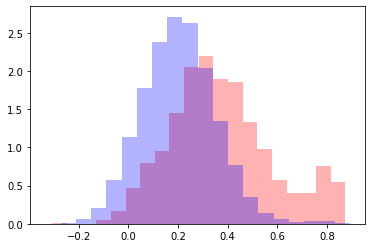

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.05482456140350877, 0.075, 0.0633445945945946, None) 0.76


In [30]:
similarity_matrix = (np.matmul(dev_embeds_lez_norm[:1000], np.transpose(dev_embeds_ru_norm)[:1000]))
s  = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k = 1)]
u_max_f, u_best_thr = get_optimal_quality(np.diagonal(similarity_matrix), s)
print(u_max_f, u_best_thr)

In [31]:
sents_lez_labse_embedded = [EmbededRuToks(sent.split()) for sent in lez_data_dev]
sents_lez_labse_embedded_norm = normalize(sents_lez_labse_embedded, axis=1, norm='l2')

1000 499500


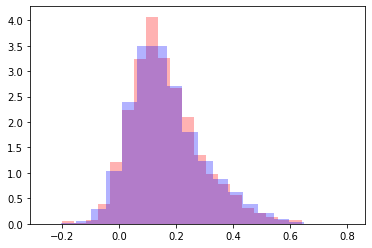

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0020432904375145846, 0.718, 0.004074984250583153, None) 0.09


In [32]:
similarity_matrix = (np.matmul(sents_lez_labse_embedded_norm[:1000], np.transpose(dev_embeds_ru_norm)[:1000]))
s  = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k = 1)]  
u_max_f, u_best_thr = get_optimal_quality(np.diagonal(similarity_matrix), s)
print(u_max_f, u_best_thr)

## Augmentation phase

In [120]:
lez_data_untouchable = get_data('/data2/Anypair/joeynmt/test/data_lez_ru/untouchable.lez')
ru_data_untouchable = get_data('/data2/Anypair/joeynmt/test/data_lez_ru/untouchable.ru')
model.eval()
aug_embeds_lez = []
aug_embeds_ru = []
aug_batch_generator = BatchGenerator((lez_data_untouchable, ru_data_untouchable), batch_size=64)
for it, (batch_of_x, batch_of_y) in enumerate(aug_batch_generator):
        output = model(batch_of_x)
        aug_embeds_lez.append(output.detach().cpu().numpy())
        aug_embeds_ru.append(batch_of_y[0].detach().cpu().numpy())

    


In [121]:
aug_embeds_lez_norm = normalize(np.concatenate(aug_embeds_lez, axis=0), axis=1, norm='l2')
aug_embeds_ru_norm = normalize(np.concatenate(aug_embeds_ru, axis=0), axis=1, norm='l2')

In [122]:
aug_embeds_lez_norm.shape

(2000, 768)

In [123]:
path = '/data2/Anypair/joeynmt/test/data_ky_ru/large_russian_corpus/ru.ru'
with open(path, "r") as f:
    content = f.readlines()

sents_ru = [x.strip() for x in content]

with open("embeds_corpus", 'rb') as fr:
    corpus_ru = pickle.load(fr)

In [124]:
parallel_ids = []
for i in range(aug_embeds_lez_norm.shape[0]):
    if i%1000 == 0:
        print(i)
    haha = np.matmul(aug_embeds_lez_norm[i], np.transpose(np.concatenate((corpus_ru, aug_embeds_ru_norm), axis=0)))
    if max(haha) >= 0.76:
        parallel_ids.append((i,np.argmax(haha)))

0
1000


In [125]:
len(parallel_ids)

410

In [126]:
full_corpus = sents_ru + ru_data_untouchable

parallel_lez = []
parallel_ru = []
for pair in tqdm(parallel_ids):
    if (full_corpus[pair[1]] not in  parallel_ru):
        parallel_lez.append(lez_data_untouchable[pair[0]])
        parallel_ru.append(full_corpus[pair[1]])
    else:
        pass

100%|██████████| 410/410 [00:00<00:00, 250972.66it/s]


In [98]:
with open('augmented_lez_ru.lez', 'w') as f:
    for item in parallel_lez:
        f.write("%s\n" % item)

In [99]:
with open('augmented_lez_ru.ru', 'w') as f:
    for item in parallel_ru:
        f.write("%s\n" % item)

# Ky-ru

In [31]:
ky_data_train = get_data('/data2/Anypair/joeynmt/test/data_ky_ru/data/train.ky')
ru_data_train = get_data('/data2/Anypair/joeynmt/test/data_ky_ru/data/train.ru')

In [32]:
fasttext = fasttext.load_model('/data2/Anypair/joeynmt/test/data_ky_ru/cc.ky.300.bin')

In [33]:
## загружаем эмбедер для русского
labse_path = '/data2/Anypair/labse_lstm/labse_bert_model'
tokenizer = AutoTokenizer.from_pretrained(labse_path, do_lower_case=False)
bert = AutoModel.from_pretrained(labse_path).to(device)

In [34]:
trainer(count_of_epoch = 20,
        batch_size = 64,
        dataset = (ky_data_train, ru_data_train),
        model = model,
        loss_function = loss_fuction,
        optimizer = optimizer,
        lr = 0.001 #callback=call
       )

100%|██████████| 20/20 [12:10:24<00:00, 2191.20s/it]  


In [35]:
ky_data_dev = get_data('/data2/Anypair/joeynmt/test/data_ky_ru/data/dev.ky')
ru_data_dev = get_data('/data2/Anypair/joeynmt/test/data_ky_ru/data/dev.ru')

In [36]:
model.eval()
dev_embeds_ky = []
dev_embeds_ru = []
dev_batch_generator = BatchGenerator((ky_data_dev, ru_data_dev), batch_size=64)
for it, (batch_of_x, batch_of_y) in enumerate(dev_batch_generator):
        output = model(batch_of_x)
        dev_embeds_ky.append(output.detach().cpu().numpy())
        dev_embeds_ru.append(batch_of_y[0].detach().cpu().numpy())

In [39]:
dev_embeds_ky_norm = normalize(np.concatenate(dev_embeds_ky, axis=0), axis=1, norm='l2')
dev_embeds_ru_norm = normalize(np.concatenate(dev_embeds_ru, axis=0), axis=1, norm='l2')

1000 499500


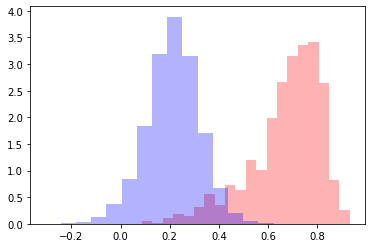

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.7138671875, 0.731, 0.7223320158102767, None) 0.62


In [42]:
similarity_matrix = (np.matmul(dev_embeds_ky_norm[:1000], np.transpose(dev_embeds_ru_norm)[:1000]))
s  = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k = 1)]
u_max_f, u_best_thr = get_optimal_quality(np.diagonal(similarity_matrix), s)
print(u_max_f, u_best_thr)

In [43]:
sents_ky_labse_embedded = [EmbededRuToks(sent.split()) for sent in ky_data_dev]
sents_ky_labse_embedded_norm = normalize(sents_ky_labse_embedded, axis=1, norm='l2')

1000 499500


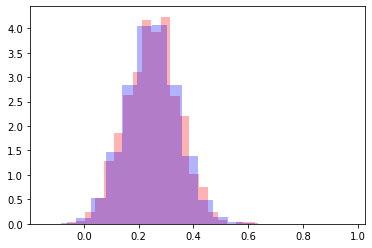

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0023534445870774497, 0.033, 0.004393556117694049, None) 0.43


In [44]:
similarity_matrix = (np.matmul(sents_ky_labse_embedded_norm[:1000], np.transpose(dev_embeds_ru_norm)[:1000]))
s  = similarity_matrix[np.triu_indices(similarity_matrix.shape[0], k = 1)]  
u_max_f, u_best_thr = get_optimal_quality(np.diagonal(similarity_matrix), s)
print(u_max_f, u_best_thr)

In [45]:
ky_data_untouchable = get_data('/data2/Anypair/joeynmt/test/data_ky_ru/data/untouchable.ky')
ru_data_untouchable = get_data('/data2/Anypair/joeynmt/test/data_ky_ru/data/untouchable.ru')
model.eval()
aug_embeds_ky = []
aug_embeds_ru = []
aug_batch_generator = BatchGenerator((ky_data_untouchable, ru_data_untouchable), batch_size=64)
for it, (batch_of_x, batch_of_y) in enumerate(aug_batch_generator):
        output = model(batch_of_x)
        aug_embeds_ky.append(output.detach().cpu().numpy())
        aug_embeds_ru.append(batch_of_y[0].detach().cpu().numpy())


In [46]:
aug_embeds_ky_norm = normalize(np.concatenate(aug_embeds_ky, axis=0), axis=1, norm='l2')
aug_embeds_ru_norm = normalize(np.concatenate(aug_embeds_ru, axis=0), axis=1, norm='l2')

In [47]:
aug_embeds_ky_norm.shape

(109682, 768)

In [48]:
path = '/data2/Anypair/joeynmt/test/data_ky_ru/large_russian_corpus/ru.ru'
with open(path, "r") as f:
    content = f.readlines()

sents_ru = [x.strip() for x in content]

with open("embeds_corpus", 'rb') as fr:
    corpus_ru = pickle.load(fr)

In [49]:
parallel_ids = []
for i in range(aug_embeds_ky_norm.shape[0]):
    if i%1000 == 0:
        print(i)
    haha = np.matmul(aug_embeds_ky_norm[i], np.transpose(np.concatenate((corpus_ru, aug_embeds_ru_norm), axis=0)))
    if max(haha) >= 0.76:
        parallel_ids.append((i,np.argmax(haha)))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000


In [50]:
full_corpus = sents_ru + ru_data_untouchable

parallel_ky = []
parallel_ru = []
for pair in tqdm(parallel_ids):
    if (full_corpus[pair[1]] not in  parallel_ru):
        parallel_ky.append(ky_data_untouchable[pair[0]])
        parallel_ru.append(full_corpus[pair[1]])
    else:
        pass
    

100%|██████████| 37244/37244 [00:09<00:00, 4081.85it/s]


In [53]:
with open('augmented_ky_ru_lstm.ky', 'w') as f:
    for item in parallel_ky:
        f.write("%s\n" % item)

In [54]:
with open('augmented_ky_ru_lstm.ru', 'w') as f:
    for item in parallel_ru:
        f.write("%s\n" % item)